# Lecture 04 - Logistic Regression


## Import required packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc


In [2]:
!pip install dmba
!pip install mord

from mord import LogisticIT
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score, accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9886 sha256=403f4472fc8adbafe391434b53ac87bfc7d055e94fcbbfb129a9d7d20000970b
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord
Colab environment detected.


## Read Data

In [33]:
my_drive_path = "/content/drive/MyDrive/SUNY/Class Material/2024 Fall/MSA550A/Python Class Work/msa550-code-files/data/"

In [34]:
bank_df = pd.read_csv(my_drive_path + 'UniversalBank.csv')

In [35]:
bank_df

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0


In [37]:
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]

KeyError: "['ID', 'ZIP Code'] not found in axis"

In [38]:
bank_df.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Personal_Loan', 'Securities_Account', 'CD_Account',
       'Online', 'CreditCard'],
      dtype='object')

## Bank Data - Model with a Single Predictor


In [29]:
# Define predictors and outcome
predictors = ['Income']  # We will first use only 'Income' as the predictor
outcome = 'Personal_Loan'

In [30]:
y = bank_df[outcome]
X = bank_df[predictors]

In [31]:
X

,Income
0,49
1,34
2,11
3,100
4,45
...,...
4995,40
4996,15
4997,24
4998,49


In [10]:
# Partition data into training and validation sets
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
print(f"Training set size: {train_X.shape}, Validation set size: {valid_X.shape}")


Training set size: (3000, 1), Validation set size: (2000, 1)


## Build a Model

In [11]:
logit_reg = LogisticRegression()


# We are creating a model with default strategies. We can define many different paramters in each of the models we define.
# FOR EXAMPLE:
"""
logit_reg = LogisticRegression(
    penalty="l2",    # Regularization type ('l2' = Ridge regularization, 'l1' = Lasso regularization, 'elasticnet' = combination of both, 'none' = no regularization)
    C=1e42,          # Inverse of regularization strength. Smaller values imply stronger regularization (default is 1.0). A very large value like 1e42 essentially disables regularization.
    solver='liblinear',  # Optimization algorithm to use. Options:
                         #   - 'liblinear': Good for small datasets, supports L1 and L2 penalties, binary classification
                         #   - 'lbfgs': Recommended for multiclass problems (more than 2 classes), supports L2 and none penalties, efficient with large datasets
                         #   - 'newton-cg': Like 'lbfgs', supports L2 and none penalties, good for large datasets
                         #   - 'sag': Stochastic average gradient descent, good for large datasets, supports L2 and none penalties
                         #   - 'saga': Extension of 'sag', supports L1, L2, and elasticnet penalties, also good for large datasets
    max_iter=100,    # Maximum number of iterations the solver will take before stopping. Default is 100. Increase this if your model isn't converging.
    random_state=1,  # Seed for random number generation, used for reproducibility of results.
    class_weight=None,  # Weights associated with classes. Options:
                       #   - None: No class weighting (default)
                       #   - 'balanced': Adjusts weights inversely proportional to class frequencies (useful for imbalanced datasets)
                       #   - dict: Manually specify weights for each class
    multi_class='auto',  # Determines how to handle multiclass classification. Options:
                         #   - 'auto': Chooses 'ovr' (one-vs-rest) for binary classification or small datasets, 'multinomial' for larger datasets
                         #   - 'ovr': One-vs-rest, fits one classifier per class
                         #   - 'multinomial': Fits a single classifier for all classes, works best with 'lbfgs', 'newton-cg', or 'saga' solvers
    verbose=0,        # Controls verbosity of the solver. Set to >0 for more detailed logging of the optimization process.
    tol=1e-4,         # Tolerance for stopping criteria. If the change in the loss function is smaller than `tol`, the algorithm stops.
    fit_intercept=True,  # Whether to fit an intercept term (bias). Default is True. Set to False if your data is already centered.
    intercept_scaling=1, # Only used when `solver='liblinear'`. It scales the intercept when fit_intercept is True.
    n_jobs=None       # Number of CPU cores used for parallel computation. Only relevant for solvers that support parallelism ('sag', 'saga', 'lbfgs').
)

"""




logit_reg.fit(train_X, train_y)

LogisticRegression()

In [13]:
print(f'Intercept: {logit_reg.intercept_[0]}')
print(f'Coefficient: {logit_reg.coef_[0][0]}')

Intercept: -6.062680137865385
Coefficient: 0.03643881318059151


## Evaluate Model Performance

In [14]:
# Evaluate model performance
print("Training Set Performance:")
classificationSummary(train_y, logit_reg.predict(train_X))
print("-------------------------------------------------")
print("Validation Set Performance:")
classificationSummary(valid_y, logit_reg.predict(valid_X))

# Calculate and print AIC for the model
print(f'AIC: {AIC_score(valid_y, logit_reg.predict(valid_X), df=len(predictors) + 1)}')

Training Set Performance:
Confusion Matrix (Accuracy 0.9080)

       Prediction
Actual    0    1
     0 2632   81
     1  195   92
-------------------------------------------------
Validation Set Performance:
Confusion Matrix (Accuracy 0.9110)

       Prediction
Actual    0    1
     0 1763   44
     1  134   59
AIC: 843.5163143186965


In [15]:
# Predicting class labels and probabilities for the validation set
# 'predict' returns the predicted class labels (0 or 1)
# 'predict_proba' returns the predicted probabilities for each class (0 and 1)

logit_reg_pred = logit_reg.predict(valid_X)           # Predicted class labels (0 or 1)
logit_reg_proba = logit_reg.predict_proba(valid_X)    # Predicted probabilities for class 0 and class 1


In [16]:
# Create a DataFrame to store the actual values, predicted probabilities, and predicted class labels
logit_result = pd.DataFrame({
    'actual': valid_y,                               # Actual target variable (0 or 1)
    'p(0)': logit_reg_proba[:, 0],                   # Probability of class 0
    'p(1)': logit_reg_proba[:, 1],                   # Probability of class 1
    'predicted': logit_reg_pred                      # Predicted class label
})

In [17]:
# display four different cases
interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.952656  0.047344          0
932        0  0.878844  0.121156          0
2721       1  0.439982  0.560018          1
702        1  0.890011  0.109989          0


In [18]:
# Confusion matrices provide insight into how well the classifier is performing
# They show TP (True Positive), TN (True Negative), FP (False Positive), and FN (False Negative) counts.
# This helps evaluate the model's performance at the default cutoff of 0.5

print("Confusion Matrix for Training Set")
classificationSummary(train_y, logit_reg.predict(train_X))   # Classification summary for training data

print("\nConfusion Matrix for Validation Set")
classificationSummary(valid_y, logit_reg.predict(valid_X))   # Classification summary for validation data

Confusion Matrix for Training Set
Confusion Matrix (Accuracy 0.9080)

       Prediction
Actual    0    1
     0 2632   81
     1  195   92

Confusion Matrix for Validation Set
Confusion Matrix (Accuracy 0.9110)

       Prediction
Actual    0    1
     0 1763   44
     1  134   59


In [19]:
# Custom threshold for classification
custom_threshold = 0.4  # Example: Adjust the threshold to 0.4 instead of 0.5

# Convert probabilities into predictions using the custom threshold
train_pred_custom = (logit_reg.predict_proba(train_X)[:, 1] >= custom_threshold).astype(int)
valid_pred_custom = (logit_reg.predict_proba(valid_X)[:, 1] >= custom_threshold).astype(int)

print("Confusion Matrix for Training Set with Custom Threshold (0.4)")
classificationSummary(train_y, train_pred_custom)  # Classification summary for training set with custom threshold

print("\nConfusion Matrix for Validation Set with Custom Threshold (0.4)")
classificationSummary(valid_y, valid_pred_custom)  # Classification summary for validation set with custom threshold


Confusion Matrix for Training Set with Custom Threshold (0.4)
Confusion Matrix (Accuracy 0.9050)

       Prediction
Actual    0    1
     0 2601  112
     1  173  114

Confusion Matrix for Validation Set with Custom Threshold (0.4)
Confusion Matrix (Accuracy 0.9105)

       Prediction
Actual    0    1
     0 1741   66
     1  113   80


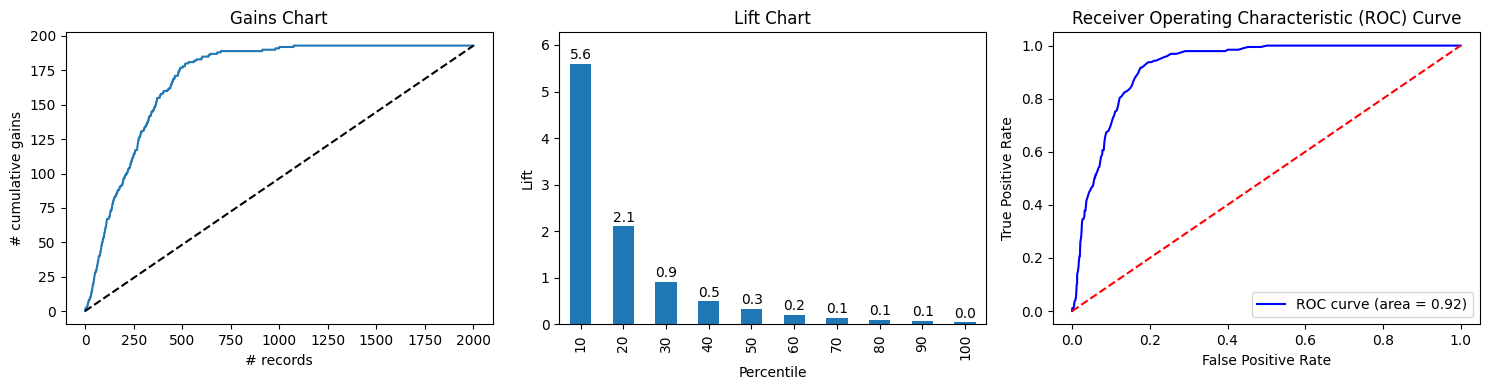

In [20]:

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(valid_y, logit_reg_proba[:, 1])

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Sort the logistic regression results DataFrame by the predicted probability of class 1 (p(1))
df = logit_result.sort_values(by=['p(1)'], ascending=False)

# Create subplots for the Gains Chart, Lift Chart, and ROC Curve
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Plot a Gains Chart on the first subplot (left-hand side)
gainsChart(df.actual, ax=axes[0])
axes[0].set_title("Gains Chart")  # Set title for Gains Chart

# Plot a Lift Chart on the second subplot (middle)
liftChart(df['p(1)'], title=False, ax=axes[1])
axes[1].set_title("Lift Chart")  # Set title for Lift Chart

# Plot ROC Curve on the third subplot (right-hand side)
axes[2].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
axes[2].plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random chance
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[2].legend(loc='lower right')

# Adjust the layout of the plots to prevent overlap and improve the appearance of the figure
plt.tight_layout()

# Display the plots
plt.show()


### Interpretation of Gains, Lift, and ROC Charts
**Gains Chart Interpretation:**

The Gains Chart displays the cumulative numer (or percentage) of actual positive cases (in this case, individuals who accepted a personal loan) against the cumulative percentage of cases (both positive and negative) as you move through the sorted list of predicted probabilities.
The X-axis represents the number of cases, while the Y-axis shows the cumulative number of actual positives.

**Analyzing the Curve:**

- The curve indicates how many of the actual positive cases are captured as you evaluate a certain percentage of the highest predicted probabilities.

- For instance, if you consider the top 20% of the cases (ranked by the model), the Gains Chart tells you what percentage of all actual positives you have captured in this group.

- A steeper curve signifies better model performance, meaning you can capture a higher percentage of positives with a smaller sample size.

**Example Interpretation:**

If the Gains Chart shows that capturing the top 30% of predicted cases includes 70% of the actual positives, this indicates that the model is effective at identifying potential loan applicants likely to accept the offer.


**Lift Chart Interpretation:**

The Lift Chart compares the performance of the logistic regression model against random selection. It shows how much better the model is at identifying positive cases compared to random guessing.
The X-axis represents the percentage of cases (like the Gains Chart), and the Y-axis indicates the lift value.
Analyzing Lift Values:

- A lift value greater than 1 indicates that the model performs better than random chance. For example, a lift of 2 at the top 20% means that the model is two times more effective at identifying positives than if you selected cases randomly.
- The higher the lift, the more effective the model is at distinguishing between the positive and negative classes.

**Example Interpretation:**

If the Lift Chart shows a lift of 3 at the top 10%, it suggests that by targeting only the top 10% of predicted cases, you would find three times as many actual positives compared to a random selection of the same size. This means your marketing efforts can be more focused and effective.


**ROC Curve Interpretation:**

The ROC (Receiver Operating Characteristic) curve visualizes the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) at various threshold settings.
The X-axis represents the false positive rate, while the Y-axis shows the true positive rate.
Analyzing the Curve:

- A model that performs well will have a ROC curve that bows towards the top left corner of the plot, indicating a high true positive rate with a low false positive rate.
- The area under the ROC curve (AUC) quantifies model performance. An AUC of 1 indicates perfect model performance, while an AUC of 0.5 suggests no discrimination ability.

**Example Interpretation:**

If the ROC curve has an AUC of 0.85, this indicates that the model has a good ability to distinguish between those who will accept a personal loan and those who will not. The closer the AUC is to 1, the better the model's predictive capability.

## Finding a good cut-off value

In [21]:
# Create a DataFrame to hold the predicted probabilities from the logistic regression model
pred_proba_df = pd.DataFrame(logit_reg.predict_proba(valid_X))

# Define a list of threshold values to evaluate model predictions
threshold_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45,
                  0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

# Iterate through each threshold to assess model performance
for i in threshold_list:
    print('\n******** For threshold = {:.2f} ******'.format(i))  # Display the current threshold being evaluated

    # Apply the threshold to the predicted probabilities to generate binary predictions
    # If probability > threshold, assign 1 (positive class), else assign 0 (negative class)
    # We use .iloc[:, 1] to focus on the probabilities for the positive class
    Y_test_pred = (pred_proba_df.iloc[:, 1] > i).astype(int)  # Create binary predictions directly

    # Calculate the accuracy of the predictions compared to the actual values
    test_accuracy = accuracy_score(valid_y, Y_test_pred)

    # Print the calculated accuracy for the current threshold
    print('Our testing accuracy is {:.4f}'.format(test_accuracy))

    # Display a detailed classification summary for the predictions
    print(classificationSummary(valid_y, Y_test_pred))



******** For threshold = 0.05 ******
Our testing accuracy is 0.7770
Confusion Matrix (Accuracy 0.7770)

       Prediction
Actual    0    1
     0 1369  438
     1    8  185
None

******** For threshold = 0.10 ******
Our testing accuracy is 0.8455
Confusion Matrix (Accuracy 0.8455)

       Prediction
Actual    0    1
     0 1525  282
     1   27  166
None

******** For threshold = 0.15 ******
Our testing accuracy is 0.8725
Confusion Matrix (Accuracy 0.8725)

       Prediction
Actual    0    1
     0 1599  208
     1   47  146
None

******** For threshold = 0.20 ******
Our testing accuracy is 0.8890
Confusion Matrix (Accuracy 0.8890)

       Prediction
Actual    0    1
     0 1648  159
     1   63  130
None

******** For threshold = 0.25 ******
Our testing accuracy is 0.8925
Confusion Matrix (Accuracy 0.8925)

       Prediction
Actual    0    1
     0 1677  130
     1   85  108
None

******** For threshold = 0.30 ******
Our testing accuracy is 0.8985
Confusion Matrix (Accuracy 0.8985)



## Building the full model

In [39]:
# Logistic Regression with Multiple Predictors

# Treat 'Education' as a categorical variable and convert it to dummy variables
# Changing the data type of 'Education' to 'category' for better handling
bank_df['Education'] = bank_df['Education'].astype('category')

# Renaming categories for better interpretability
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}
bank_df.Education.cat.rename_categories(new_categories)

,Education
0,Undergrad
1,Undergrad
2,Undergrad
3,Graduate
4,Graduate
...,...
4995,Advanced/Professional
4996,Undergrad
4997,Advanced/Professional
4998,Graduate


In [40]:
# Creating dummy variables for categorical features
# Using drop_first=True to avoid multicollinearity by dropping the first category
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

In [41]:
bank_df.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage',
       'Personal_Loan', 'Securities_Account', 'CD_Account', 'Online',
       'CreditCard', 'Education_2', 'Education_3'],
      dtype='object')

In [42]:
# Define the target variable 'y' and the feature set 'X'
y = bank_df['Personal_Loan']  # Target variable
X = bank_df.drop(columns=['Personal_Loan'])  # Features (dropping the target)


In [43]:
X

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_2,Education_3
0,25,1,49,4,1.6,0,1,0,0,0,False,False
1,45,19,34,3,1.5,0,1,0,0,0,False,False
2,39,15,11,1,1.0,0,0,0,0,0,False,False
3,35,9,100,1,2.7,0,0,0,0,0,True,False
4,35,8,45,4,1.0,0,0,0,0,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,40,1,1.9,0,0,0,1,0,False,True
4996,30,4,15,4,0.4,85,0,0,1,0,False,False
4997,63,39,24,2,0.3,0,0,0,0,0,False,True
4998,65,40,49,3,0.5,0,0,0,1,0,True,False


In [44]:
# Partition the data into training and validation sets
# Using 40% of the data for validation and 60% for training
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [45]:
# Fit a logistic regression model
# Setting penalty='l2' and C=1e42 to effectively disable regularization
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, solver='liblinear')

In [46]:
# Output the intercept and coefficients of the logistic regression model
print('Intercept: ', logit_reg.intercept_[0])  # Intercept term
print(pd.DataFrame({'Coefficient': logit_reg.coef_[0]}, index=X.columns))  # Coefficients for each feature

# Print a separator for clarity in output
print("-------------------------------------------------")

Intercept:  -12.493436061176814
                    Coefficient
Age                   -0.037685
Experience             0.039202
Income                 0.058844
Family                 0.612251
CCAvg                  0.240489
Mortgage               0.001012
Securities_Account    -1.014280
CD_Account             3.649097
Online                -0.678306
CreditCard            -0.958283
Education_2            4.202148
Education_3            4.355761
-------------------------------------------------


In [47]:
# Display classification summary for training set predictions
classificationSummary(train_y, logit_reg.predict(train_X))
print("-------------------------------------------------")

Confusion Matrix (Accuracy 0.9600)

       Prediction
Actual    0    1
     0 2683   30
     1   90  197
-------------------------------------------------


In [48]:
# Calculate and print AIC (Akaike Information Criterion) for model evaluation
# AIC helps assess the model fit considering the number of parameters
print('AIC: ', AIC_score(valid_y, logit_reg.predict(valid_X), df=len(train_X.columns) + 1))

AIC:  -709.1524769205962


In [49]:
# Display classification summary for validation set predictions
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1791   16
     1   65  128


In [50]:
### Converting Predictions to Probabilities

# Generate predictions for the validation set
logit_reg_pred = logit_reg.predict(valid_X)  # Predicted class labels (0 or 1)

# Obtain predicted probabilities for both classes (0 and 1)
logit_reg_proba = logit_reg.predict_proba(valid_X)  # Probabilities for each class

# Create a DataFrame to summarize the results
logit_result = pd.DataFrame({
    'actual': valid_y,  # Actual class labels from the validation set
    'p(0)': [p[0] for p in logit_reg_proba],  # Probability of class 0
    'p(1)': [p[1] for p in logit_reg_proba],  # Probability of class 1
    'predicted': logit_reg_pred  # Predicted class labels based on the highest probability
})

# Define a list of interesting cases (indices) to analyze
interestingCases = [2764, 932, 2721, 702]

# Display the actual and predicted results for the specified interesting cases
print(logit_result.loc[interestingCases])  # Output the selected cases from the results DataFrame


      actual      p(0)      p(1)  predicted
2764       0  0.976092  0.023908          0
932        0  0.331000  0.669000          1
2721       1  0.031430  0.968570          1
702        1  0.985893  0.014107          0
